## Aim  of the project

This project has been realized in order to understand if some of the features that characterise a song are more relevant than others for predicting two chosen metric of success for the song.

The two metrics that we looked at are the song's **popularity** and its reception between musics enthusists, we have labeled this as **critic score**.

# The Dataset

The dataset is the result of merging together a dataset representing the `Rate Your Music top 500 tracks` leaderboard and a dataset obtained scraping through `Spotify API` a playlist containing those same tracks.

* **popularity_normalized** &rarr; `minmax scaling` of the metric provided by the `Spotify API`
* **critic score** &rarr; augmented knowledge, scaling of the position in RYM ranking computed as `1 - minmax(ranking)` in excel

* **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

* **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

* **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

* **instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values *above 0.5* are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

* **liveness**:
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value *above 0.8* provides strong likelihood that the track is live.

* **speechiness**:
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values *above 0.66* describe tracks that are probably made entirely of spoken words. Values *between 0.33 and 0.66* describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values *below 0.33* most likely represent music and other non-speech-like tracks.

* **valence**:
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with *high valence* sound *more positive* (e.g. happy, cheerful, euphoric), while tracks with *low valence* sound *more negative* (e.g. sad, depressed, angry).

* **tempo**:
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

In [1]:
# importing useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sep = ";"
sns.set_palette("Set2") # set seaborn color palette
pal = sns.color_palette('Set2') # get colors for highlighting the quantiles

In [2]:
df = pd.read_csv('data.csv',sep=sep)

In [3]:
df.head() # inspecting the data

,track_name,artists,album,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,popularity,year,ranking,critic score,popularity_normalized
0,Wouldn't It Be Nice,The Beach Boys,Greatest Hits,0.385,0.657,5,-6.975,1,0.0342,0.724000,...,0.1050,0.672,124.895,153867,4,60,2012,1,1,"0,6125"
1,God Only Knows,The Beach Boys,50 Big Ones: Greatest Hits,0.433,0.469,6,-9.853,0,0.0320,0.156000,...,0.0479,0.334,115.876,175787,4,51,2012,1,1,"0,5"
2,Sinnerman,Nina Simone,Pastel Blues,0.436,0.543,11,-13.351,0,0.0962,0.654000,...,0.0937,0.663,148.282,622000,4,63,1965,2,"0,997995992","0,65"
3,How to Disappear Completely,Radiohead,Kid A,0.167,0.302,6,-11.644,0,0.0345,0.316000,...,0.1100,0.190,102.026,356333,4,67,2000,3,"0,995991984","0,7"
4,when you sleep,my bloody valentine,loveless,0.399,0.866,6,-9.720,1,0.0558,0.000034,...,0.0785,0.125,128.864,251947,4,62,1991,4,"0,993987976","0,6375"


Dropping columns which are not useful to our analysis

In [4]:
df = df.drop(['time_signature','mode','key','liveness','popularity','ranking'],axis=1)

## Pre-processing columns

In this section we prepare the columns `year` and `duration_ms` for discretization

* **year**: Convert release date to the decade the album was released in order to discretize the value in order to obtain the **'decade'** column. The column has been kept in numerical format, not casted to a string of the type '1920s', because it would conflict with the discretization.

For example by writing 2010 we mean the decade going from to 2010 to 2019

In [5]:
df['decade'] = (10 * (df['year'] // 10)) 

In [6]:
#Printing the min and max values of Release date in order to better discretize the release date 
# column
print(np.min(df['decade']), np.max(df['decade']))

1920 2020


### Approximate duration into minutes

* **duration_ms**: Through a helper function we convert duration_ms into **'duration_min '**
 


The get_min function takes as input an int value in milliseconds and converts it into an integer
that corresponds to the nearest minute. For example, that means that if a duration in milliseconds 
is equal 3 minutes and 30 seconds it is approximated to the nearest minute which is 4.



In [7]:
def get_min(ms):
    minutes=float(ms/float(1000*60))%60.
    return int((round(minutes,0)))

print(get_min(210000),'minutes') # 210000 milliseconds is equal to 3 minutes and 30 seconds
print(get_min(209000),'minutes') # 209000 milliseconds is equal to 3 minutes and 29 seconds

4 minutes
3 minutes


In [8]:
df['duration_min'] = df['duration_ms'].apply(lambda x: get_min(x)) # use apply function to use the get min function on every row of the get_min column

In [9]:
# drop rows with songs that are too long
df1 = df.drop(df[df.duration_min > 15].index,axis=0) 

In [10]:
# Remove live songs
df2=df1.drop(df1[df1['album'].str.contains("live", case=False)].index,axis=0)

In [11]:
df2.head()

,track_name,artists,album,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,duration_ms,year,critic score,popularity_normalized,decade,duration_min
0,Wouldn't It Be Nice,The Beach Boys,Greatest Hits,0.385,0.657,-6.975,0.0342,0.724000,0.000000,0.672,124.895,153867,2012,1,"0,6125",2010,3
1,God Only Knows,The Beach Boys,50 Big Ones: Greatest Hits,0.433,0.469,-9.853,0.0320,0.156000,0.000000,0.334,115.876,175787,2012,1,"0,5",2010,3
2,Sinnerman,Nina Simone,Pastel Blues,0.436,0.543,-13.351,0.0962,0.654000,0.000009,0.663,148.282,622000,1965,"0,997995992","0,65",1960,10
3,How to Disappear Completely,Radiohead,Kid A,0.167,0.302,-11.644,0.0345,0.316000,0.797000,0.190,102.026,356333,2000,"0,995991984","0,7",2000,6
4,when you sleep,my bloody valentine,loveless,0.399,0.866,-9.720,0.0558,0.000034,0.738000,0.125,128.864,251947,1991,"0,993987976","0,6375",1990,4


In [12]:
df2=df2.drop(["duration_ms","year"],axis=1) # drop columns which are no longer useful 

In [13]:
df2.dtypes #check if all data datatypes are ok

track_name                object
artists                   object
album                     object
danceability             float64
energy                   float64
loudness                 float64
speechiness              float64
acousticness             float64
instrumentalness         float64
valence                  float64
tempo                    float64
critic score              object
popularity_normalized     object
decade                     int64
duration_min               int64
dtype: object

`critic score` is treated as an object therefore we need to check if it is a `string` 

In [14]:
print("Checking type of  critic score .... ")
type_c = type(df2['critic score'][0])
type_c

Checking type of  critic score .... 


str

In [15]:
# critic score was a string so we are casting it to a float
df2['critic score'] = df2['critic score'].str.replace(',','.') # change decimal to dot instead of comma
df2['critic score'] = df2['critic score'].astype(float)
df2.dtypes # Now critic score is a float , need to repeat the same with popularity_normalized    

track_name                object
artists                   object
album                     object
danceability             float64
energy                   float64
loudness                 float64
speechiness              float64
acousticness             float64
instrumentalness         float64
valence                  float64
tempo                    float64
critic score             float64
popularity_normalized     object
decade                     int64
duration_min               int64
dtype: object

Repeat the same with popularity

In [16]:
# popularity_normalized was a string so we are casting it to a float
df2['popularity_normalized'] = df2['popularity_normalized'].str.replace(',','.') # change decimal to dot instead of comma
df2['popularity_normalized'] = df2['popularity_normalized'].astype(float)
df2.dtypes     

track_name                object
artists                   object
album                     object
danceability             float64
energy                   float64
loudness                 float64
speechiness              float64
acousticness             float64
instrumentalness         float64
valence                  float64
tempo                    float64
critic score             float64
popularity_normalized    float64
decade                     int64
duration_min               int64
dtype: object

### Inspecting relationship between variables

We want to understand if we can extract some knowledge on the relationship between the variables by looking at the correlation between them.

We make 2 correlation plots, one for `critic score` and one for `popularity_normalized` because if we have both `critic score` and `popularity_scal` the correlation plot is difficult to read, moreover **we have chosen to use `pearson` correlation because it is the most useful and simple one to understand linear relation between two variables.** Lastly, we drop `popularity` which was already processed.

In [17]:
# drop not relevant columns
dfp=df2.drop(["critic score"],axis=1)

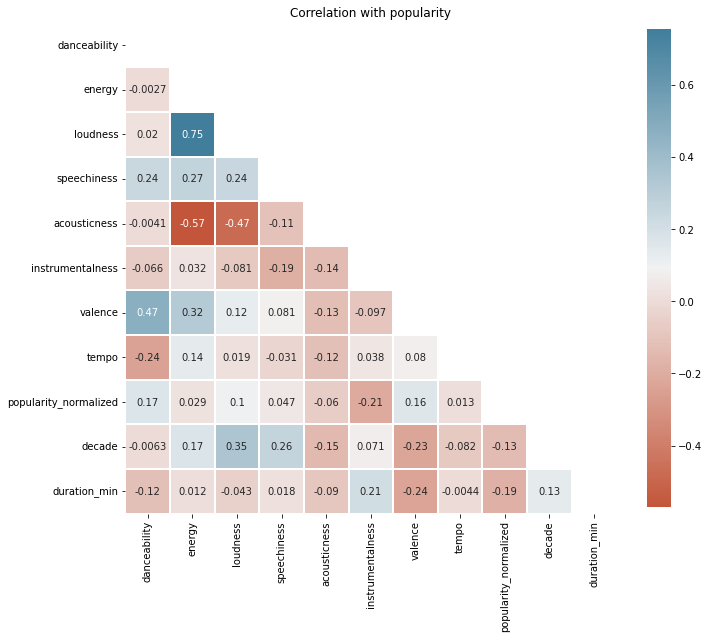

In [18]:
plt.figure(figsize=(11,11))
plt.title("Correlation with popularity")
corr = dfp.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            mask=mask, 
            annot=True, 
            cmap=sns.diverging_palette(20, 230, as_cmap=True),   
            square = True,                                 
            linewidths = 1.5,
            cbar_kws = {"shrink": .8});

In [19]:
dfc=df2.drop(["popularity_normalized"],axis=1)

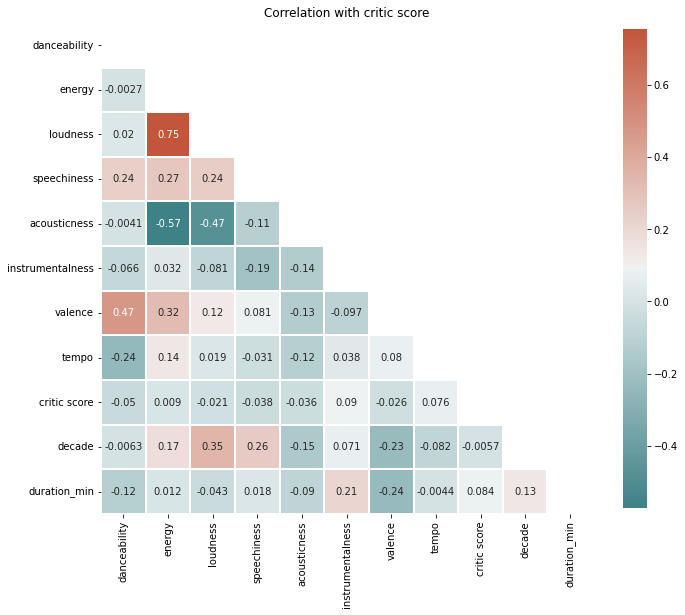

In [20]:
plt.figure(figsize=(11,11))
corr = dfc.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.title("Correlation with critic score")
sns.set_palette("Set2")
sns.heatmap(corr, 
            mask=mask, 
            annot=True, 
            cmap=sns.diverging_palette(200, 20, as_cmap=True),   
            square = True,                                 
            linewidths = 1.5,
            cbar_kws = {"shrink": .8});

The correlation plot of `popularity_normalized` is particularly useful because it highlights a lot of relationship between our variables. Instead from the `critic score` plot we cannot deduce any useful relation. We have chosen a minimum threshold for correlation which is 0.18 in order to inspect only the most useful pairs of nodes

#### Getting most correlated pairs of variables

In [21]:
corr_df = dfc.corr().abs() # we are interested in extracting the magnitude of the correlation
corr_series = corr_df.unstack() # Convert the corr_df to a pandas series
corr_series_sorted = corr_series.sort_values(kind="quicksortedrt",ascending=False) 
no_dup = corr_series_sorted[(corr_series_sorted < 0.9 ) & (corr_series_sorted >= 0.18)].drop_duplicates()
no_dup

loudness      energy              0.754051
acousticness  energy              0.571057
              loudness            0.474788
valence       danceability        0.474150
decade        loudness            0.348556
valence       energy              0.316167
energy        speechiness         0.271381
speechiness   decade              0.258126
loudness      speechiness         0.242535
danceability  tempo               0.241476
speechiness   danceability        0.237682
valence       duration_min        0.235908
decade        valence             0.230263
duration_min  instrumentalness    0.214456
speechiness   instrumentalness    0.188608
dtype: float64

In [22]:
print(f"There are {len(no_dup)} pairs above the selected correlation threshold")

There are 15 pairs above the selected correlation threshold


We are going to use this knowledge about the correlation between variables when constructing the bayesian network.

# Discretization


## Pre-processed columns
These columns are relatively easy to discretize because they are not purely numerical domain dependant attributes and we are able to use common knowledge about the musical domain for defining labels' ranges.

### 1. decade &rarr; musical era

Each discretized decade has been mapped into a label in the column **'era'** . For the labels we used some kind of intuition to determine the labels associated with each group of decade.  



The rationale is:

-  Albums released in a decade in range `[1910-1970]` are considered as **vintage**. This is a reasonable assumption considering 1970 was 50 years ago.

- Albums released in a decade in range `[1980-2000]` are considered as **modern**.

- Albums released in a decade in range `[2010-2020]` are considered as **contemporary**.

In [23]:
df2['era']=pd.cut(x=df2['decade'], bins=[1910,1970,2000,2020], 
                        labels=["vintage","modern","contemporary"])

### 2. duration_min &rarr; dur

Now we are going to inspect the `duration_min` variable by looking at two kind of plots:
1. we look at the distribution of values of duration_min in our dataset according to standard quantiles (i.e. first, second and third quantile)
2. we look at the distribution of values of duration_min according to knowledge about the musical domain. (i.e. [according to Billboard Hot 100 data "popular songs are, on average, 3 minutes and 30 seconds long"](https://www.musicianwave.com/whats-the-average-length-of-a-song-year/#:~:text=The%20average%20length%20of%20a%20song%20can%20change%20over%20time,minutes%20and%2030%20seconds%20long.))

Plots with standard quantiles

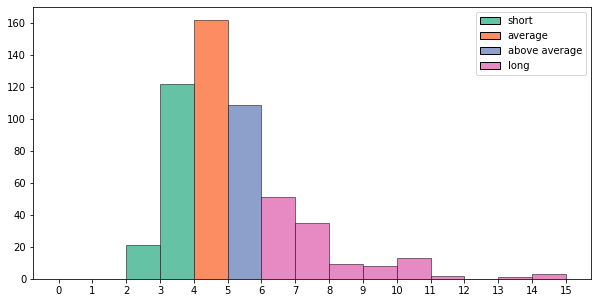

In [24]:
from matplotlib.patches import Rectangle # used for drawing colored patches

fig, ax = plt.subplots(figsize = (10,5))
cols = pal.as_hex()[:4] # save colors for labeling of quantiles
N, bins, patches = ax.hist(df2.duration_min,bins=range(np.max(df2.duration_min)+1), edgecolor='black', linewidth=0.5)

#get standard the first, second and third quantile
quant_25, quant_50, quant_75= int(df2.duration_min.quantile(0.25)),int(df2.duration_min.quantile(0.50)),int(df2.duration_min.quantile(0.75))

# color each patch with one of the colors
for i in range(0,quant_25+1):
    patches[i].set_facecolor(cols[0])
for i in range(quant_25+1 ,quant_50+1):    
    patches[i].set_facecolor(cols[1])
for i in range(quant_50+1, quant_75+1):
    patches[i].set_facecolor(cols[2])
for i in range(quant_75+1, len(patches)):
    patches[i].set_facecolor(cols[3])

#create legend for labels
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in  cols]
labels= ["short","average","above average","long"] # labels we want to use for discretization
plt.xticks(np.arange(0, max(df2.duration_min)+1, 1.0)) # set x-axis range
plt.legend(handles, labels)
plt.show()

The standard quantiles of our data are not useful for assigning labels for discretization because they do not represent the distribution of songs on average.

This is because we want to understand the relationship of song duration with respect to its success within music enthusiasts. So for example our hypothesis is that a song that is longer may be more critically acclaimed because it may contain long instrumental components whereas a commercial pop song has an average duration of 3 minutes and 30 seconds.

Plots with standard values for song duration:
- a song duration below 3 minutes is considered as *short*
- a song duration between 3 and 4 minutes is considered as *average*
- a song duration between 4 and 6 minutes is *above average*
- a song duration above 6 is considered as *long*

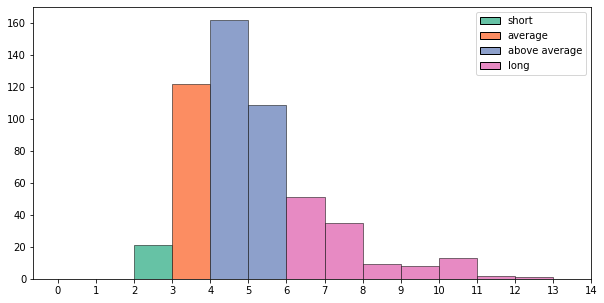

In [25]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (10,5))
cols = pal.as_hex()[:4]
N, bins, patches = ax.hist(df2.duration_min,bins=range(14), edgecolor='black', linewidth=0.5)

for i in range(0,3):
    patches[i].set_facecolor(cols[0])
for i in range(3 ,4):    
    patches[i].set_facecolor(cols[1])
for i in range(4, 6):
    patches[i].set_facecolor(cols[2])
for i in range(6, len(patches)):
    patches[i].set_facecolor(cols[3])

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in  cols]
labels= ["short","average","above average","long"]
plt.xticks(np.arange(0, max(df2.duration_min), 1.0))
plt.legend(handles, labels)
plt.show()

In [26]:
df2['dur']=pd.cut(x=df2['duration_min'],bins=[0,2,3,5,np.max(df2.duration_min)+1], 
                        labels=["short","average","above average","long"])

In [27]:
# Drop unused columns
df2 = df2.drop(["decade","duration_min"],axis=1)

In [28]:
df2[df2.isnull().any(axis=1)] #  Check if everything is ok with the dataframe

,track_name,artists,album,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,critic score,popularity_normalized,era,dur


## Raw numerical columns

Now we need to discretize columns for which we need to rely on pre-existing knowledge provided by the `Spotify API` or, if this is not provided, using quantiles to compute the discretization. In order to better understand these columns we need to plot the histogram for those.

In [29]:
column_list=df2.columns.tolist()
print(df2.columns.tolist())

['track_name', 'artists', 'album', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'critic score', 'popularity_normalized', 'era', 'dur']


We exclude the columns which were already processed (`era`,`dur`) and `'track_name', 'artists', 'album'` which are not relevant for discretization.

In [30]:
non_str_col = [col for col in df2.columns if col not in ['track_name', 'artists', 'album','era', 'dur']] 
print(non_str_col, '\n')
print(f'There are {len(non_str_col)} columns which do not have entries with str dtype')

['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'critic score', 'popularity_normalized'] 

There are 10 columns which do not have entries with str dtype


Inspecting histograms for understand which columns we can plot together

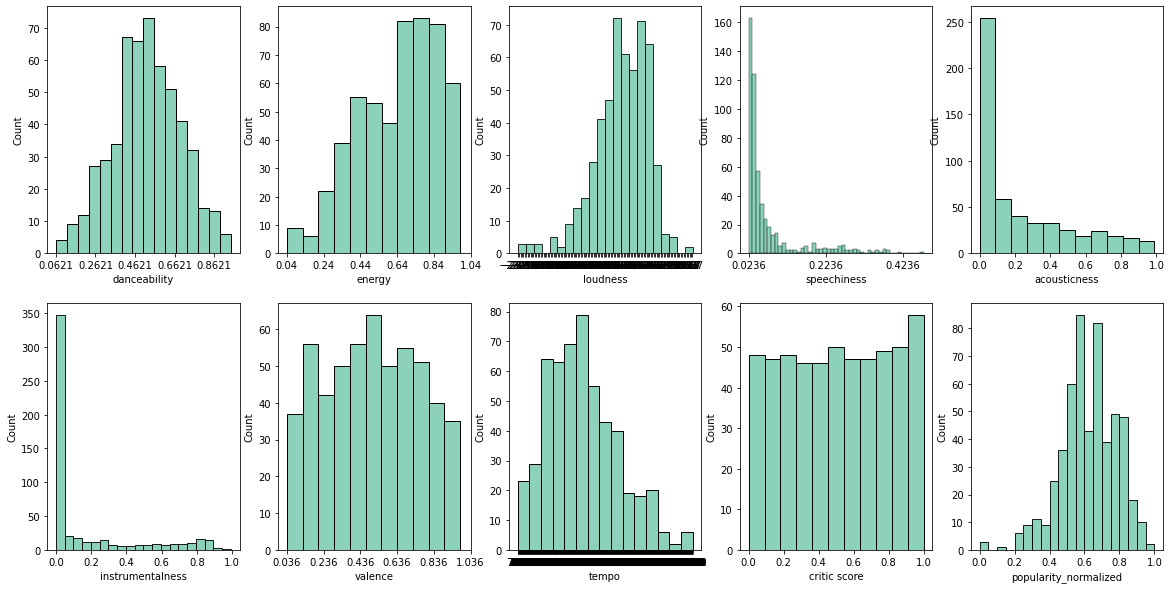

In [31]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes = [axis for subl in axes for axis in subl]
for col, ax in zip(non_str_col, axes):
    sns.histplot(x=col, data=df2, ax=ax)
    ax.set_xticks(np.arange(min(df2[col]), max(df2[col])+0.1, step=0.2))

From this plot we can see that:

- The `tempo` and `loudness` column have a lot of unique value therefore we will need to visualize them one by one, same can be said for `speechiness`
- `valence`, `energy` and `danceability` have similar ranges of values
- `instrumentalness`, `acousticness` can be looked at together because they have a lot of values stacked towards zero
- `critic score` and `popularity` will be inspected together

### tempo, loudness and speechiness

In [32]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10

* **tempo**:
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

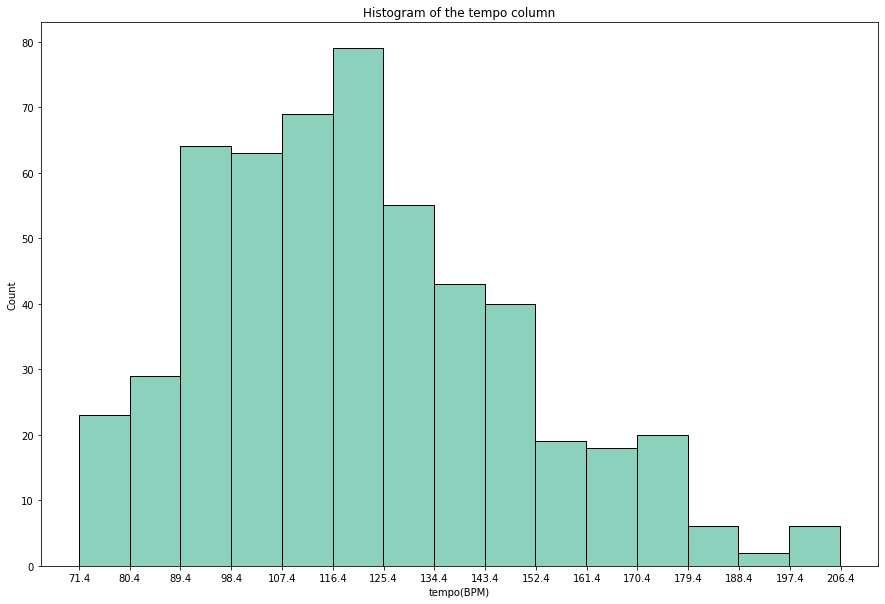

In [33]:
sns.histplot(x="tempo", data=df2)
plt.xlabel("tempo(BPM)")
plt.title("Histogram of the tempo column")
plt.xticks(np.arange(min(df2["tempo"]), max(df2["tempo"])+9, step=9));

From the plot we cannot deduce meaningful conclusions, therefore we will use quantiles.

In [34]:
print(("The minimum and maximum value of the tempo column are respectively {} and {}").format(np.min(df2.tempo), np.max(df2.tempo)))

The minimum and maximum value of the tempo column are respectively 71.398 and 206.247


In [35]:
quant_25_t, quant_50_t, quant_75_t= int(df2.tempo.quantile(0.25)),int(df2.tempo.quantile(0.50)),int(df2.tempo.quantile(0.75))
df2['tem']=pd.cut(x=df2['tempo'], bins=[np.min(df2.tempo)-0.1,quant_25_t,quant_50_t,np.max(df2.tempo)], 
                        labels=["slow tempo","medium tempo","high tempo"])

* **loudness**: The overall loudness of a track in decibels (*dB*). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 dB.

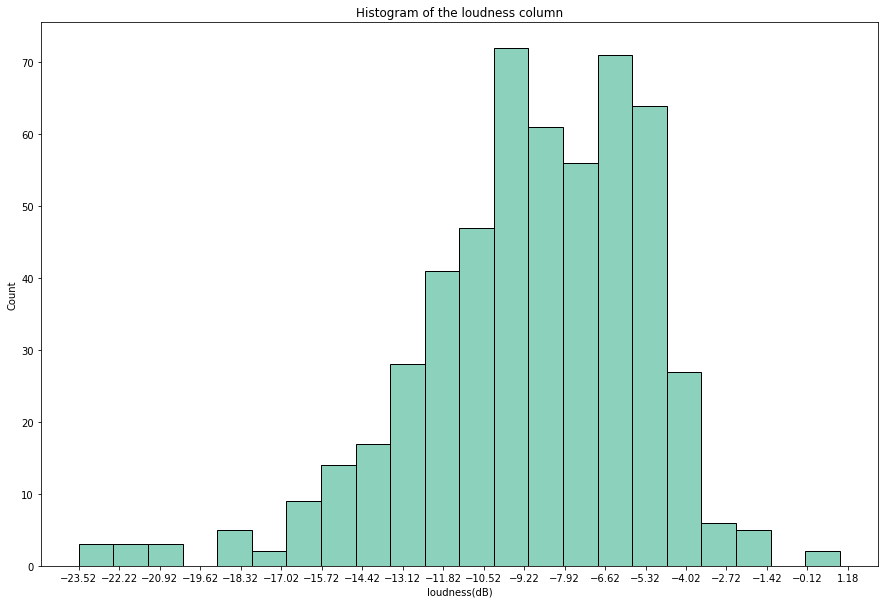

In [36]:
sns.histplot(x="loudness", data=df2)
plt.title("Histogram of the loudness column")
plt.xlabel("loudness(dB)")
plt.xticks(np.arange(min(df2["loudness"]), max(df2["loudness"]+1.3), step=1.3));

We cannot infer much from this plot

In [37]:
quant_25_l, quant_50_l, quant_75_l= int(df2.loudness.quantile(0.25)),int(df2.loudness.quantile(0.50)),int(df2.loudness.quantile(0.75))
df2['loud']=pd.cut(x=df2['loudness'], bins=[np.min(df2.loudness)-0.1,quant_25_l,quant_50_l,np.max(df2.loudness)], 
                        labels=["quiet","average loudness","loud"])

### Speechiness

* **speechiness**:
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values *above 0.66* describe tracks that are probably made entirely of spoken words. Values *between 0.33 and 0.66* describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values *below 0.33* most likely represent music and other non-speech-like tracks.



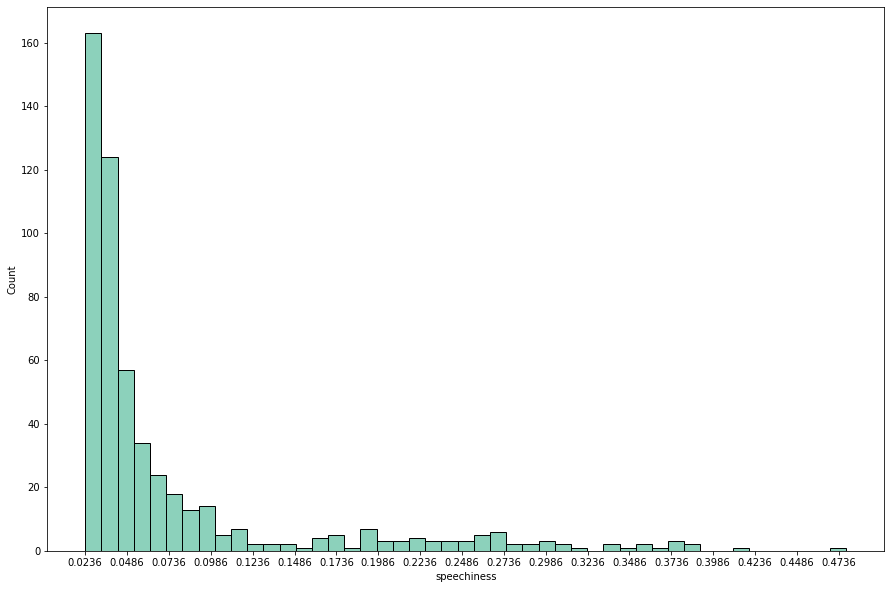

In [38]:
sns.histplot(x="speechiness", data=df2)
plt.xticks(np.arange(min(df2["speechiness"]), max(df2["speechiness"]+0.02), step=0.025));

For the discretization of the `speechiness` variable we had to use different values than the ones provided by the `Spotify API` because the spotify API also takes into account podcasts. Insted our analysis wants to distinguish standard songs and very verbose songs.

we can see a lot of data is accumulated towards the start value therefore the variable will be binary.

We choose to split according to the second quantile because the variable has many values towards the start of the data range.

In [39]:
quant_25_s, quant_50_s, quant_75_s= round(df2.speechiness.quantile(0.25),2),round(df2.speechiness.quantile(0.50),3),round(df2.speechiness.quantile(0.75),3)
df2['speech']=pd.cut(x=df2['speechiness'], bins=[0,quant_50_s,np.max(df2.speechiness)], 
                        labels=["standard word density","high word density"])

In [40]:
df2 = df2.drop(["speechiness","loudness","tempo"],axis=1)

## Grouped columns

We split the data according to the division discussed above.

In [41]:
column_list = df2.columns.tolist()
print(column_list)

['track_name', 'artists', 'album', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'critic score', 'popularity_normalized', 'era', 'dur', 'tem', 'loud', 'speech']


In [42]:
group1 = ['danceability', 'energy','valence']
group2 = ['acousticness', 'instrumentalness']
group3 = ['critic score', 'popularity_normalized']

## Group 1: 'danceability', 'energy', 'valence'

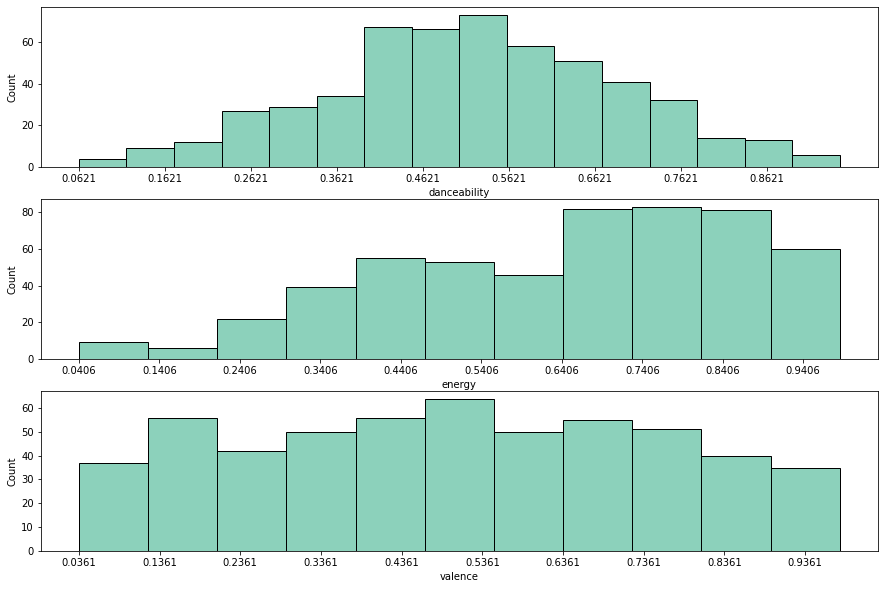

In [43]:
_, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
for col, ax in zip(group1, axes):
    sns.histplot(x=col, data=df2, ax=ax)
    ax.set_xticks(np.arange(min(df2[col]), max(df2[col]), step=0.1))

* **valence**:
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with *high valence* sound *more positive* (e.g. happy, cheerful, euphoric), while tracks with *low valence* sound *more negative* (e.g. sad, depressed, angry).


In [44]:
quant_25_v, quant_50_v, quant_75_v= df2.valence.quantile(0.25),df2.valence.quantile(0.50),df2.valence.quantile(0.75)
df2['val']=pd.cut(x=df2['valence'], bins=[np.min(df2.valence)-0.1,quant_25_v,quant_50_v,1], 
                        labels=["sad","neutral","euphoric"])


* **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.




In [45]:
quant_25_d, quant_50_d, quant_75_d= round(df2.danceability.quantile(0.25),3),round(df2.danceability.quantile(0.50),3),round(df2.danceability.quantile(0.75),3)
df2['dan']=pd.cut(x=df2['danceability'], bins=[-1,quant_25_d,quant_50_d,1], 
                        labels=["low danceability","standard danceability","high danceability"])

* **energy**: is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

In [46]:
quant_25_e, quant_50_e, quant_75_e= round(df2.energy.quantile(0.25),3),round(df2.energy.quantile(0.50),3),round(df2.energy.quantile(0.75),3)
df2['ene']=pd.cut(x=df2['energy'], bins=[-.01,quant_25_e,quant_50_e,1], 
                        labels=["slow","medium","energic"])

In [47]:
df2 = df2.drop(group1,axis=1)

## Group 2: 'acousticness', 'instrumentalness' 

These two columns are very polarized towards zero therefore a boolean discretization is required

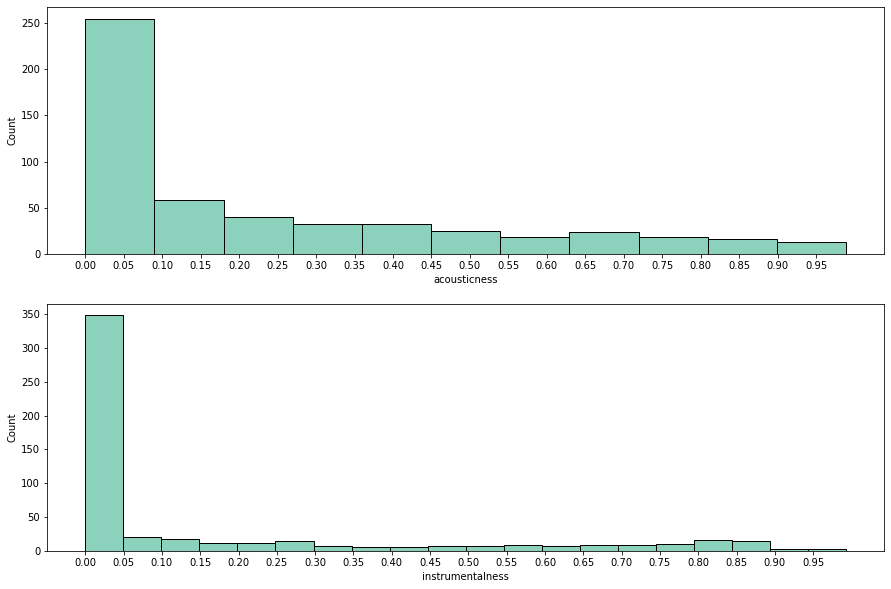

In [48]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
for col, ax in zip(group2, axes):
    sns.histplot(x=col, data=df2, ax=ax)
    ax.set_xticks(np.arange(min(df2[col]), max(df2[col]), step=0.05))



* **instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values *above 0.5* are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.


In [49]:
quant_25_i, quant_50_i, quant_75_i= df2.instrumentalness.quantile(0.25),round(df2.instrumentalness.quantile(0.50),4),round(df2.instrumentalness.quantile(0.75),4)
df2['instr']=pd.cut(x=df2['instrumentalness'], bins=[-.01,quant_50_i,np.max(df2.instrumentalness)], 
                        labels=["not instrumental","instrumental"])
# this column has been discretizated as boolean 

* **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.


In [50]:
quant_25_a, quant_50_a, quant_75_a= round(df2.acousticness.quantile(0.25),3),round(df2.acousticness.quantile(0.50),3),round(df2.acousticness.quantile(0.75),3)
df2['aco']=pd.cut(x=df2['acousticness'], bins=[-.01,quant_50_a,1], 
                        labels=["not acoustic","acoustic"]) 
# this column has been discretizated as boolean 

In [51]:
df2 =df2.drop(group2,axis=1)

## Group 3: 'Popularity', 'Critic score'

* **Popularity**: The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. 
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. 
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity

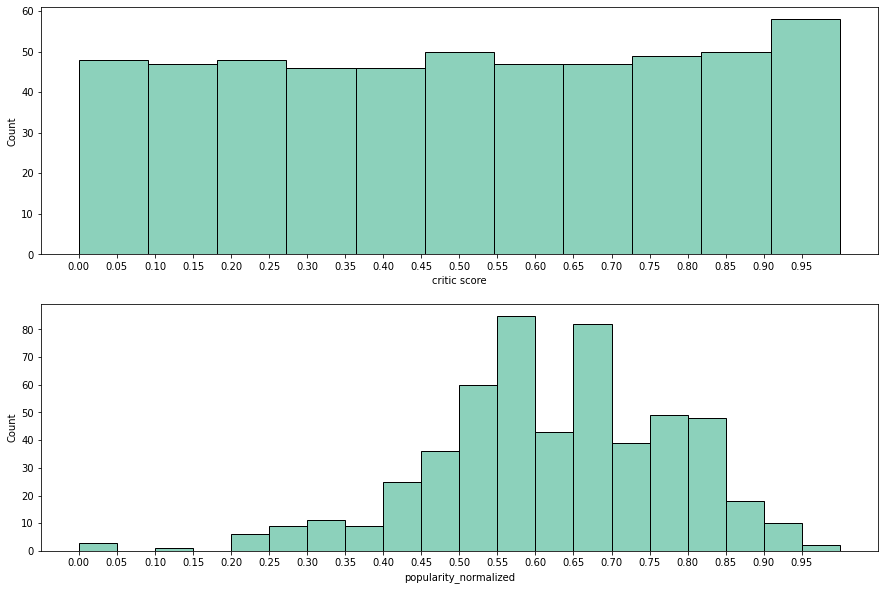

In [52]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
for col, ax in zip(group3, axes):
    sns.histplot(x=col, data=df2, ax=ax)
    ax.set_xticks(np.arange(min(df2[col]), max(df2[col]), step=0.05))

In [53]:
quant_25_p, quant_50_p, quant_75_p= df2.popularity_normalized.quantile(0.25),df2.popularity_normalized.quantile(0.50),df2.popularity_normalized.quantile(0.75)
df2['pop']=pd.cut(x=df2['popularity_normalized'], bins=[-.01,quant_25_p,quant_50_p,1], 
                        labels=["low popularity","standard popularity","high popularity"])

In [54]:
quant_25_c, quant_50_c, quant_75_c= round(df2['critic score'].quantile(0.25),2),round(df2['critic score'].quantile(0.50),2),round(df2['critic score'].quantile(0.75),2)
df2['crit']=pd.cut(x=df2['critic score'], bins=[-.01,quant_25_c,quant_50_c,1], 
                        labels=["low critically score","average critical score","high critical score"])

In [55]:
strings = ["track_name","artists","album"]

In [56]:
df3 = df2.drop(group3+strings, axis=1) #drop columns no longer of use
df3.head()

,era,dur,tem,loud,speech,val,dan,ene,instr,aco,pop,crit
0,contemporary,average,high tempo,loud,standard word density,euphoric,low danceability,medium,not instrumental,acoustic,standard popularity,high critical score
1,contemporary,average,medium tempo,average loudness,standard word density,neutral,standard danceability,slow,not instrumental,acoustic,low popularity,high critical score
2,vintage,long,high tempo,quiet,high word density,euphoric,standard danceability,medium,not instrumental,acoustic,high popularity,high critical score
3,modern,long,medium tempo,quiet,standard word density,sad,low danceability,slow,instrumental,acoustic,high popularity,high critical score
4,modern,above average,high tempo,average loudness,high word density,sad,low danceability,energic,instrumental,not acoustic,high popularity,high critical score


# Network structure

In order to restrict the scope of the project columns which are irrelevant and are too specific
to handle only attributes that have been considered particularly relevant were considered. 

From the preprocessing we have obtained the following discretization, the variables name have been shortened to make the network more compact. A description of each abbreviation for readibility.

- year &rarr; 'era',
- duration_ms &rarr; 'dur',
- instrumentalness &rarr; 'instr',
- speechiness &rarr; 'speech',
- valence &rarr; 'val',
- danceability &rarr; 'dan',
- acousticness &rarr; 'aco',
- popularity &rarr; 'pop',
- critic score &rarr; 'crit',
- tempo &rarr; 'tem',
- loudness &rarr; 'loud',
- energy &rarr; 'ene'

Connections between nodes have been implemented firstly by looking at correlation between columns and by reasoning about independence and relationship between variables.   

# Bayesian network example


### Analyzing the network

In [57]:
from pgmpy.models import BayesianModel 

In [58]:
import daft
import matplotlib.pyplot as plt
from daft import PGM

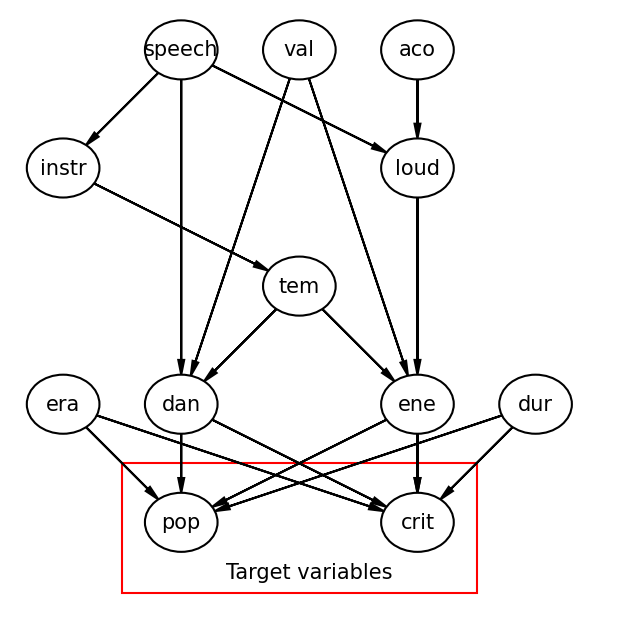

In [59]:
pgm = daft.PGM(aspect=1.23,directed=True,dpi=150,shape=[5,5])
plt.rcParams["figure.facecolor"] = "w"

# Defining the nodes

pgm.add_node(daft.Node('speech', r"speech", 2, 5))
pgm.add_node(daft.Node('aco', r"aco", 4, 5))
pgm.add_node(daft.Node('val', r"val", 3,5))

pgm.add_node(daft.Node('instr', r"instr", 1, 4))
pgm.add_node(daft.Node('loud', r"loud", 4, 4))

pgm.add_node(daft.Node('tem', r"tem", 3, 3))
pgm.add_node(daft.Node('ene', r"ene", 4, 2))
pgm.add_node(daft.Node('dan', r"dan", 2, 2))
pgm.add_node(daft.Node('era', r"era", 1, 2))
pgm.add_node(daft.Node('dur', r"dur", 5, 2))


pgm.add_node(daft.Node('pop', r"pop", 2, 1))
pgm.add_node(daft.Node('crit', r"crit", 4, 1))

#edges

pgm.add_edge('instr', 'tem')
pgm.add_edge('speech', 'instr')
pgm.add_edge('speech', 'loud')
pgm.add_edge('speech', 'dan')

pgm.add_edge('aco', 'loud')
pgm.add_edge('val', 'dan')
pgm.add_edge('val', 'ene')

pgm.add_edge('loud', 'ene')
pgm.add_edge('tem', 'ene')
pgm.add_edge('tem', 'dan')

pgm.add_edge('dan', 'pop')
pgm.add_edge('dan', 'crit')
pgm.add_edge('ene', 'crit')
pgm.add_edge('dur', 'crit')
pgm.add_edge('era', 'crit')
pgm.add_edge('era', 'pop')
pgm.add_edge('ene', 'crit')
pgm.add_edge('ene', 'pop')
pgm.add_edge('dur', 'pop')

pgm.add_plate([1.5,0.5,3, 1],label=r"Target variables ",shift=-0.1,label_offset=[50,5],rect_params={"ec":"red"})
pgm.render()
plt.show()

In [60]:
from pgmpy.models import BayesianNetwork

# Network analysis

To build network's connections, 3 approaches were used:

- Previous domain knowledge
- Correlation between-nodes  
- Both above-mentioned approaches

### Previous domain knowledge based connections:

| Ancestor Node | Descendant Node |
| ----------- | ----------- |
| Instrumentalness | Tempo |
| Era | Popularity |
| Era | Critic Score |
| Danceability | Critic Score |
| Energy | Popularity |
| Energy | Critic Score |
| Duration | Critic Score |

The connection between `Instrumentalness` and `Tempo` is suggested by the fact that if a song is instrumental then it will probably be slower implying lower BPM. \
The fourth and sixth connections are given by the importance that `Danceability` and `Energy` have in determing the experts' judgement thus determining the `Critic Score`.

### Correlation between-nodes based connections:

| Ancestor Node | Descendant Node | Correlation |
| ----------- | ----------- | ----------- |
| Valence | Danceability | high (0.48) |
| Valence | Energy | high (0.31) |
| Loudness | Energy | very high (0.76) |

In this case we had no idea of `valence`'s importance in determining a track's `danceability` and `energy`. These connections were completely suggested by high correlation.

### Between-nodes Correlation + Previous domain knowledge based connections:

| Ancestor Node | Descendant Node | Correlation |
| ----------- | ----------- | ----------- |
| Speechiness | Danceability | slight (0.23) |
| Speechiness | Loudness | high (0.25) |
| Speechiness | Instrumentalness | slight (0.18) |
| Acousticness | Loudness | high (0.48) |
| Tempo | Danceability | high (0.25) |
| Tempo | Energy | slight (0.15) |
| Danceability | Popularity | high (0.25) |
| Duration | Popularity | slight (0.23) |

We decided to keep those couples with correlation below our minimum (`0.18`) due to their association suggested by previous knowledge in musical domain. In fact, we know how `tempo` is really important in determining a track's `energy`.

## Model creation

Create bayesian model from the daft PGM model

In [61]:
def convert_pgm_to_pgmpy(pgm):
    """Takes a Daft PGM object and converts it to a pgmpy BayesianModel"""
    edges = [(edge.node1.name, edge.node2.name) for edge in pgm._edges]
    model = BayesianModel(edges)
    return model

In [62]:
model = convert_pgm_to_pgmpy(pgm)

In [63]:
model.nodes() # displaying model's nodes

NodeView(('instr', 'tem', 'speech', 'loud', 'dan', 'aco', 'val', 'ene', 'pop', 'crit', 'dur', 'era'))

In [64]:
model.edges() # displaying edges between nodes

OutEdgeView([('instr', 'tem'), ('tem', 'ene'), ('tem', 'dan'), ('speech', 'instr'), ('speech', 'loud'), ('speech', 'dan'), ('loud', 'ene'), ('dan', 'pop'), ('dan', 'crit'), ('aco', 'loud'), ('val', 'dan'), ('val', 'ene'), ('ene', 'crit'), ('ene', 'pop'), ('dur', 'crit'), ('dur', 'pop'), ('era', 'crit'), ('era', 'pop')])

#### Local independecies

In [65]:
for node in model.nodes():
    print(f"node {node} ==> {model.local_independencies(node)}")

node instr ==> (instr ⟂ aco, val, era, loud, dur | speech)
node tem ==> (tem ⟂ aco, val, speech, era, loud, dur | instr)
node speech ==> (speech ⟂ aco, era, val, dur)
node loud ==> (loud ⟂ dan, instr, val, tem, era, dur | aco, speech)
node dan ==> (dan ⟂ aco, ene, instr, era, loud, dur | tem, val, speech)
node aco ==> (aco ⟂ era, dan, val, tem, instr, speech, dur)
node val ==> (val ⟂ era, aco, tem, instr, loud, speech, dur)
node ene ==> (ene ⟂ aco, dan, instr, speech, era, dur | loud, val, tem)
node pop ==> (pop ⟂ aco, val, crit, tem, instr, loud, speech | era, ene, dan, dur)
node crit ==> (crit ⟂ aco, val, pop, tem, instr, loud, speech | era, ene, dan, dur)
node dur ==> (dur ⟂ aco, val, tem, speech, instr, loud, era, ene, dan)
node era ==> (era ⟂ aco, val, tem, speech, instr, loud, ene, dan, dur)


In the above cell are printed all the local independencies for each of the node of the network. We can see that by fixing the value for some nodes we can stop the flow of influence between other nodes.

For example if we fix the `speechiness` of a song its `instrumentalness` is independent of [loud, era, dur, val, aco] because if we know the speechiness of the song the flow of influence to  these variables is interrupted .


Another example is the node `dan`, if we have pre-acquired knowledge of the nodes `val,tem,speech` the flow of influences to ` instr,loud,ene`

#### Directly connected nodes

This method returns True if there is an active trail (i.e. d-connection) between start and end node given that observed is added into the evidence".

In [66]:
print(model.is_dconnected("speech", "ene")) 
print(model.is_dconnected("speech", "ene", \
    observed=["loud","tem"] )) 
print()
print("Common cause and indirect effect example: ")
print("Speech val and tem not in evidence:",model.is_dconnected("dan", "ene")) 
print("Speech val and tem in evidence:",model.is_dconnected("dan", "ene", \
    observed=["speech","val","tem"] ))
print()
print("V-structure example: ")
print("Crit not in evidence:",model.is_dconnected("dan", "dur"))
print("Crit (descendant) in evidence: ",model.is_dconnected("dan", "dur", \
    observed=["crit"] ))
    #blocking all paths to dan

True
False

Common cause and indirect effect example: 
Speech val and tem not in evidence: True
Speech val and tem in evidence: False

V-structure example: 
Crit not in evidence: False
Crit (descendant) in evidence:  True


In the above cell we are checking the d-separation between variables first by having no evidence and then by adding some nodes to the evidence.

From the above cell we can see that:
1. the `ene` and `speech` node are not d-separated because there is an active trail from: `speech` &rarr; `loud` &rarr; `ene` 

2. In this case we have put into the evidence the nodes `loud,val,tem` therefore blocking all paths that lead to `speech`.

3. The V-structure is a case opposite to the previous one, if crit is in the knowledge then there is an active trail going from `dan` to `dur`


#### Active trail nodes

In [67]:
# Checking active trails from energy  given variable evidence in order to block paths
print("only tem in evidence: \n")
print(model.active_trail_nodes('ene', observed=['tem']),"\n")
print("tem and speech in evidence: \n")
print(model.active_trail_nodes('ene', observed=['speech','tem']),"\n")
print("tem, speech and loud in evidence: \n")
print(model.active_trail_nodes('ene', observed=['speech','tem','loud']),"\n")
print("Activating V-Structure through pop: \n")
print(model.active_trail_nodes('ene', observed=['pop','speech','tem','loud']))


only tem in evidence: 

{'ene': {'aco', 'val', 'pop', 'speech', 'instr', 'loud', 'ene', 'dan', 'crit'}} 

tem and speech in evidence: 

{'ene': {'aco', 'ene', 'dan', 'val', 'pop', 'crit', 'loud'}} 

tem, speech and loud in evidence: 

{'ene': {'ene', 'dan', 'val', 'pop', 'crit'}} 

Activating V-Structure through pop: 

{'ene': {'ene', 'dan', 'val', 'crit', 'era', 'dur'}}


Through the observed field we blocked some of the paths that can reach the node `ene` while letting others through. We can observe that:

* `pop` and `crit`  can reach energy from the path immediately below
* `val` can reach energy from the path immediately above
* `dan` can reach energy from only `val` because the path through `speech` and `tem` have been blocked by fixing the nodes.
* in the last case we can see that there are additional active trails because `pop` is in evidence therefore `era` and `dur` are added into the set of active trails.

In [68]:
# Checking the markov blanket of the node ene
model.get_markov_blanket("tem") 

['val', 'speech', 'instr', 'loud', 'ene', 'dan']

The markov blanket of `tem` is composed by:
- parents: `instr`
- children: `dan`,`ene`
- children's parents: `speech`,`val`,`loud`  

### Parameter learning

In this section we estimate the CPDs

In [69]:
from pgmpy.estimators import BayesianEstimator

model.cpds = []
model.fit(data=df3, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

CPT of instr:
+-------------------------+-----+-------------------------------+
| speech                  | ... | speech(standard word density) |
+-------------------------+-----+-------------------------------+
| instr(instrumental)     | ... | 0.5600375234521576            |
+-------------------------+-----+-------------------------------+
| instr(not instrumental) | ... | 0.4399624765478424            |
+-------------------------+-----+-------------------------------+ 

CPT of tem:
+-------------------+---------------------+-------------------------+
| instr             | instr(instrumental) | instr(not instrumental) |
+-------------------+---------------------+-------------------------+
| tem(high tempo)   | 0.5465187923598275  | 0.45779420825631545     |
+-------------------+---------------------+-------------------------+
| tem(medium tempo) | 0.24337646333949475 | 0.2803450400492914      |
+-------------------+---------------------+-------------------------+
| tem(slow tempo)   

In [70]:
# Checking the validity of the model 
model.check_model()

True

In [71]:
#Cardinality of all model nodes
model.get_cardinality()

defaultdict(int,
            {'instr': 2,
             'tem': 3,
             'speech': 2,
             'loud': 3,
             'dan': 3,
             'aco': 2,
             'val': 3,
             'ene': 3,
             'pop': 3,
             'crit': 3,
             'dur': 4,
             'era': 3})

We can see we have high cardinality for variables, this was a modeling choice to capture the nuances of some variables that could not be simply casted to boolean and needed to be discretized in a way that captured the complexity of the data. 

##  Inferences

###  Exact Inference

In [72]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

#### Casual inference

Will the song be popular if its valence is `sad` but the tempo is `high`? 


In [73]:
print(infer.query(["pop"],evidence={"val": "sad", "tem": "high tempo"}))

+--------------------------+------------+
| pop                      |   phi(pop) |
+==========================+============+
| pop(high popularity)     |     0.4420 |
+--------------------------+------------+
| pop(low popularity)      |     0.3120 |
+--------------------------+------------+
| pop(standard popularity) |     0.2459 |
+--------------------------+------------+


We can see that having val =`sad` in the evidence lowers a bit the probability high popularity.

In [74]:
print(infer.query(["pop"],evidence={"val": "euphoric", "tem": "high tempo"}))

+--------------------------+------------+
| pop                      |   phi(pop) |
+==========================+============+
| pop(high popularity)     |     0.4865 |
+--------------------------+------------+
| pop(low popularity)      |     0.2616 |
+--------------------------+------------+
| pop(standard popularity) |     0.2519 |
+--------------------------+------------+


#### Evidential inference


explaining the probability of a song being energic given that it received an high critical score.

In [75]:
print(infer.query(["ene"],evidence={"crit": "high critical score"}))

+--------------+------------+
| ene          |   phi(ene) |
+==============+============+
| ene(energic) |     0.5276 |
+--------------+------------+
| ene(medium)  |     0.2017 |
+--------------+------------+
| ene(slow)    |     0.2706 |
+--------------+------------+


We can see here that a song that has an high critical score it is most likely to be `energic`.

#### Intercausal inference

Now we want to see why a song received an high critical score given it wasn't energetic

In [76]:
print(infer.query(["dan"],evidence={"crit": "high critical score", "ene": "medium"}))

+----------------------------+------------+
| dan                        |   phi(dan) |
+============================+============+
| dan(high danceability)     |     0.5478 |
+----------------------------+------------+
| dan(low danceability)      |     0.1828 |
+----------------------------+------------+
| dan(standard danceability) |     0.2694 |
+----------------------------+------------+


From the above table can say there is a slightly more chance that the song received an high critical score whilst while having a medium energy because of high danceability.

### Predicting values from new data points

MAP query: getting the most probable state of the variable

In [77]:
#Infer MAP queries
print(infer.map_query(["loud"]))
print(infer.map_query(["loud"], evidence={'speech': "high word density"}))
print(infer.map_query(["loud"], evidence={'speech': "standard word density", 'aco': "not acoustic"}))
print(infer.map_query(["loud"], evidence={'speech': "standard word density", 'aco': "acoustic"}))


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'loud': 'loud'}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'loud': 'loud'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'loud': 'loud'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'loud': 'quiet'}


We can see the loudness most probable value changing by fixing different values for the variable that directly influences it. In general the most probable value for loudness is loud, except when we add into the evidence that a song has a `standard word density` and is `acoustic`.

### Approximate Inference

In [78]:
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling

infer = ApproxInference(model)
inference = BayesianModelSampling(model)

Sampling from an empty network

In [80]:
# Showing the convergence to true probability by incresing the number of samples 

print("10 samples:")
print(infer.query(variables=["crit"], n_samples=10)) 
print("\n 1000 samples: ")
print(infer.query(variables=["crit"], n_samples=1000)) 
print("\n 10000 samples: ")
print(infer.query(variables=["crit"], n_samples=10000)) 

print("\n True probability:")
print(VariableElimination(model).query(["crit"]))     

10 samples:


  0%|          | 0/12 [00:00<?, ?it/s]

+------------------------------+-------------+
| crit                         |   phi(crit) |
+==============================+=============+
| crit(average critical score) |      0.1000 |
+------------------------------+-------------+
| crit(high critical score)    |      0.5000 |
+------------------------------+-------------+
| crit(low critically score)   |      0.4000 |
+------------------------------+-------------+

 1000 samples: 


  0%|          | 0/12 [00:00<?, ?it/s]

+------------------------------+-------------+
| crit                         |   phi(crit) |
+==============================+=============+
| crit(average critical score) |      0.2590 |
+------------------------------+-------------+
| crit(high critical score)    |      0.4650 |
+------------------------------+-------------+
| crit(low critically score)   |      0.2760 |
+------------------------------+-------------+

 10000 samples: 


  0%|          | 0/12 [00:00<?, ?it/s]

+------------------------------+-------------+
| crit                         |   phi(crit) |
+==============================+=============+
| crit(average critical score) |      0.2584 |
+------------------------------+-------------+
| crit(high critical score)    |      0.4795 |
+------------------------------+-------------+
| crit(low critically score)   |      0.2621 |
+------------------------------+-------------+

 True probability:
+------------------------------+-------------+
| crit                         |   phi(crit) |
+==============================+=============+
| crit(average critical score) |      0.2572 |
+------------------------------+-------------+
| crit(high critical score)    |      0.4734 |
+------------------------------+-------------+
| crit(low critically score)   |      0.2694 |
+------------------------------+-------------+


We can see that the values of the variables in the last two tables are really close to each other.

In [354]:
# Showing output of the sampling process
print(inference.likelihood_weighted_sample(size=5))

  0%|          | 0/12 [00:00<?, ?it/s]

              instr         tem             speech              loud  \
0      instrumental  slow tempo  high word density              loud   
1      instrumental  high tempo  high word density              loud   
2  not instrumental  slow tempo  high word density              loud   
3      instrumental  high tempo  high word density             quiet   
4  not instrumental  slow tempo  high word density  average loudness   

                     dan           aco       val      ene  \
0       low danceability  not acoustic       sad  energic   
1  standard danceability  not acoustic       sad  energic   
2      high danceability      acoustic       sad  energic   
3  standard danceability  not acoustic   neutral  energic   
4      high danceability      acoustic  euphoric   medium   

                   pop                  crit            dur      era  _weight  
0      high popularity  low critically score        average   modern      1.0  
1      high popularity   high critical s

In [84]:
# Likelihood sampling
print(infer.get_distribution(inference.likelihood_weighted_sample(size=100), ["pop"], joint=True))

  0%|          | 0/12 [00:00<?, ?it/s]

+--------------------------+------------+
| pop                      |   phi(pop) |
+==========================+============+
| pop(high popularity)     |     0.5200 |
+--------------------------+------------+
| pop(low popularity)      |     0.2300 |
+--------------------------+------------+
| pop(standard popularity) |     0.2500 |
+--------------------------+------------+


In [85]:
# Rejection sampling
print(infer.get_distribution(inference.rejection_sample(size=100), ["pop"]))

  0%|          | 0/12 [00:00<?, ?it/s]

+--------------------------+------------+
| pop                      |   phi(pop) |
+==========================+============+
| pop(high popularity)     |     0.4300 |
+--------------------------+------------+
| pop(low popularity)      |     0.2700 |
+--------------------------+------------+
| pop(standard popularity) |     0.3000 |
+--------------------------+------------+


###  Query 1:

In [203]:
infer = VariableElimination(model)

Da rifare in maniera simile


In [204]:
era_value = df3.era.unique()
pop_value = df3['pop'].unique()
for pop in pop_value:
  for era in era_value:
    print("Probability ofthe danceability given the popularity and musical era :",pop,era) 
    print(infer.query(["dan"], evidence={"pop":pop,"era":era}))

Probability ofthe danceability given the popularity and musical era : standard popularity contemporary
+----------------------------+------------+
| dan                        |   phi(dan) |
+============================+============+
| dan(high danceability)     |     0.4833 |
+----------------------------+------------+
| dan(low danceability)      |     0.2452 |
+----------------------------+------------+
| dan(standard danceability) |     0.2715 |
+----------------------------+------------+
Probability ofthe danceability given the popularity and musical era : standard popularity vintage
+----------------------------+------------+
| dan                        |   phi(dan) |
+============================+============+
| dan(high danceability)     |     0.4593 |
+----------------------------+------------+
| dan(low danceability)      |     0.2712 |
+----------------------------+------------+
| dan(standard danceability) |     0.2695 |
+----------------------------+------------+
Probabi

We can see a more danceable song tends to be more popular

###  Query 2: 

What's the difference in danceability between songs that are sad and with a standard word density, and tracks that are euphoric and verbose?

Discuss results here

In [205]:
print("standard word density and sad")
print(infer.query(["ene"], evidence={"speech": 'standard word density', "val":'sad'}))
print("high word density and sad")
print(infer.query(["ene"], evidence={"speech": 'high word density', "val":'sad'}))
print("standard word density and euphoric")
print(infer.query(["ene"], evidence={"speech": 'standard word density', "val":'euphoric'}))
print("high word density and euphoric")
print(infer.query(["ene"], evidence={"speech": 'high word density', "val":'euphoric'}))

standard word density and sad
+--------------+------------+
| ene          |   phi(ene) |
+==============+============+
| ene(energic) |     0.3599 |
+--------------+------------+
| ene(medium)  |     0.1707 |
+--------------+------------+
| ene(slow)    |     0.4694 |
+--------------+------------+
high word density and sad
+--------------+------------+
| ene          |   phi(ene) |
+==============+============+
| ene(energic) |     0.4686 |
+--------------+------------+
| ene(medium)  |     0.1691 |
+--------------+------------+
| ene(slow)    |     0.3623 |
+--------------+------------+
standard word density and euphoric
+--------------+------------+
| ene          |   phi(ene) |
+==============+============+
| ene(energic) |     0.5194 |
+--------------+------------+
| ene(medium)  |     0.3135 |
+--------------+------------+
| ene(slow)    |     0.1672 |
+--------------+------------+
high word density and euphoric
+--------------+------------+
| ene          |   phi(ene) |
+=======

We can see that if we fix the `valence` it has a great influence on the `danceability`, instead the `speechiness` has less, but still appreciable effect of $5\%$ on the CPT.

### Query 3:

Gotta add smth here later

In [206]:
dancs = df3['dan'].unique().sort_values()
durations = df3['dur'].unique().sort_values()

for dan in dancs:
    for dur in durations:
        print(f"Probability of being critically acclaimed given track's duration and musical era : ({dur},{dan})")
        print(infer.query(["crit"], evidence={"dur":dur, "dan":dan}))

Probability of being critically acclaimed given track's duration and musical era : (short,low danceability)
+------------------------------+-------------+
| crit                         |   phi(crit) |
+==============================+=============+
| crit(average critical score) |      0.2481 |
+------------------------------+-------------+
| crit(high critical score)    |      0.6254 |
+------------------------------+-------------+
| crit(low critically score)   |      0.1266 |
+------------------------------+-------------+
Probability of being critically acclaimed given track's duration and musical era : (average,low danceability)
+------------------------------+-------------+
| crit                         |   phi(crit) |
+==============================+=============+
| crit(average critical score) |      0.2270 |
+------------------------------+-------------+
| crit(high critical score)    |      0.4491 |
+------------------------------+-------------+
| crit(low critically score)  

###  Query 4: 

We want to analyze the difference in acousticness appreciation between music enthusiasts and casual listeners 

In [207]:
scores = df3['crit'].unique().sort_values()
pop_vals = df3['pop'].unique().sort_values()

for score in scores:
    print(score,":")
    print(infer.query(["aco"], evidence={"crit":score}))


print("\n")
for pop in pop_vals:
    print(pop,":")
    print(infer.query(["aco"], evidence={"pop":pop}))

low critically score :
+-------------------+------------+
| aco               |   phi(aco) |
+===================+============+
| aco(acoustic)     |     0.4990 |
+-------------------+------------+
| aco(not acoustic) |     0.5010 |
+-------------------+------------+
average critical score :
+-------------------+------------+
| aco               |   phi(aco) |
+===================+============+
| aco(acoustic)     |     0.5010 |
+-------------------+------------+
| aco(not acoustic) |     0.4990 |
+-------------------+------------+
high critical score :
+-------------------+------------+
| aco               |   phi(aco) |
+===================+============+
| aco(acoustic)     |     0.5000 |
+-------------------+------------+
| aco(not acoustic) |     0.5000 |
+-------------------+------------+


low popularity :
+-------------------+------------+
| aco               |   phi(aco) |
+===================+============+
| aco(acoustic)     |     0.5069 |
+-------------------+------------+
|

Discuss results here

### Query 5:

How's the tempo tendency changed during the years?

In [208]:
for val in df3.val.unique().sort_values():
    for speech in df3.speech.unique().sort_values():
        print(f"{val=} | {speech=}")
        print(infer.query(["tem"], evidence={"val":val,"speech":speech}))

val='sad' | speech='standard word density'
+-------------------+------------+
| tem               |   phi(tem) |
+===================+============+
| tem(high tempo)   |     0.5075 |
+-------------------+------------+
| tem(medium tempo) |     0.2596 |
+-------------------+------------+
| tem(slow tempo)   |     0.2329 |
+-------------------+------------+
val='sad' | speech='high word density'
+-------------------+------------+
| tem               |   phi(tem) |
+===================+============+
| tem(high tempo)   |     0.4970 |
+-------------------+------------+
| tem(medium tempo) |     0.2640 |
+-------------------+------------+
| tem(slow tempo)   |     0.2390 |
+-------------------+------------+
val='neutral' | speech='standard word density'
+-------------------+------------+
| tem               |   phi(tem) |
+===================+============+
| tem(high tempo)   |     0.5075 |
+-------------------+------------+
| tem(medium tempo) |     0.2596 |
+-------------------+----------

Discuss results here about markov blanket

### Query 6:

Are slow and instrumental tracks popular among casual listeners?

In [209]:
print(infer.query(["pop"], evidence={"ene":'slow', "instr":'instrumental'}))

+--------------------------+------------+
| pop                      |   phi(pop) |
+==========================+============+
| pop(high popularity)     |     0.4571 |
+--------------------------+------------+
| pop(low popularity)      |     0.3181 |
+--------------------------+------------+
| pop(standard popularity) |     0.2248 |
+--------------------------+------------+


In [214]:
print(infer.query(["pop"], evidence={"ene":'energic', "instr":'instrumental'}))

+--------------------------+------------+
| pop                      |   phi(pop) |
+==========================+============+
| pop(high popularity)     |     0.4767 |
+--------------------------+------------+
| pop(low popularity)      |     0.2572 |
+--------------------------+------------+
| pop(standard popularity) |     0.2661 |
+--------------------------+------------+


In [210]:
print(infer.query(["pop"], evidence={"ene":'energic', "instr":'not instrumental'}))

+--------------------------+------------+
| pop                      |   phi(pop) |
+==========================+============+
| pop(high popularity)     |     0.4778 |
+--------------------------+------------+
| pop(low popularity)      |     0.2559 |
+--------------------------+------------+
| pop(standard popularity) |     0.2662 |
+--------------------------+------------+


Discuss results here

### Query 7:

The ultimate question would be: "What parameters should a track have to be both popular and critically acclaimed?"

In [218]:
print(infer.map_query(["dur","aco","speech","instr","val","tem","loud","dan","ene"],
                        evidence={"pop":'high popularity', "crit":'high critical score'}))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'dur': 'above average', 'aco': 'not acoustic', 'speech': 'high word density', 'instr': 'not instrumental', 'val': 'euphoric', 'tem': 'high tempo', 'loud': 'loud', 'dan': 'high danceability', 'ene': 'energic'}


Based on the result, if we wanted to create a track that is both popular and critically acclaimed, it would probably have to be a positive rap song with high BPM.

## Conclusions

In this last section the main focus shifts from exploring the network and its methods, focusing on some example of real interesting applications to the given dataset.

All the important queries here shown are then briefly interpreted and discussed.

The major focus will be in investigating causes and effects of heart failures events, and related probabilities, for this reason a first general probability of having an heart failure (given our dataset) without assuming any evidence is shown and discussed

In [ ]:
df["heart_failure"].value_counts()

In [ ]:
infer = VariableElimination(model)
print(infer.query(["heart_failure"]))